# September 30 - EresNet 34 continued

In [1]:
# Imports
import sys
import os
import time
import math

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
# Fix the colour scheme for each particle type
color_dict = {"gamma":"red", "e":"blue", "mu":"green"}

# Fix the numpy seed
np.random.seed(42)

## Plot the resumed training of the EresNet-34 VAE already trained for 30.0 epochs

In [3]:
# Plot model performance over the training iterations
def plot_vae_training(log_paths, model_names, model_color_dict, downsample_interval=None,
                      legend_loc=(0.8,0.5), show_plot=False, save_path=None):
    
    # Assertions
    assert log_paths is not None
    assert model_names is not None
    assert model_color_dict is not None
    assert len(log_paths) == len(model_names)
    assert len(model_names) == len(model_color_dict.keys())
    
    # Extract the values stored in the .csv log files
    epoch_values = []
    mse_loss_values = []
    kl_loss_values = []
    
    true_epoch_values = []
    true_mse_loss_values = []
    true_kl_loss_values = []
    
    # Iterate over the list of log files provided
    for log_path in log_paths:
        if(os.path.exists(log_path)):
            log_df = pd.read_csv(log_path, usecols=["epoch", "recon_loss", "kl_loss"])
            
            # Downsample the epoch and training loss values w.r.t. the downsample interval
            curr_epoch_values = log_df["epoch"].values
            curr_mse_loss_values  = log_df["recon_loss"].values
            curr_kl_loss_values = log_df["kl_loss"].values
            
            # Downsample using the downsample interval
            
            true_epoch_values.append(curr_epoch_values)
            true_mse_loss_values.append(curr_mse_loss_values)
            true_kl_loss_values.append(curr_kl_loss_values)
                
            if downsample_interval is not None:
                curr_epoch_values_downsampled = []
                curr_mse_loss_values_downsampled  = []
                curr_kl_loss_values_downsampled  = []

                curr_epoch_list = []
                curr_mse_loss_list = []
                curr_kl_loss_list = []

                for i in range(1, len(curr_epoch_values)):

                    if(i%downsample_interval == 0):

                        # Downsample the values using the mean of the values for the current interval
                        curr_epoch_values_downsampled.append(sum(curr_epoch_list)/downsample_interval)
                        curr_mse_loss_values_downsampled.append(sum(curr_mse_loss_list)/downsample_interval)
                        curr_kl_loss_values_downsampled.append(sum(curr_kl_loss_list)/downsample_interval)
                        

                        # Reset the list for the next interval
                        curr_epoch_list = []
                        curr_mse_loss_list = []
                        curr_kl_loss_list = []
                    else:
                        # Add the values in the interval to the list
                        curr_epoch_list.append(curr_epoch_values[i])
                        curr_mse_loss_list.append(curr_mse_loss_values[i]) 
                        curr_kl_loss_list.append(curr_kl_loss_values[i]) 

                epoch_values.append(curr_epoch_values_downsampled)
                mse_loss_values.append(curr_mse_loss_values_downsampled)
                kl_loss_values.append(curr_kl_loss_values_downsampled)
        else:
            print("Error. log path {0} does not exist".format(log_path))
            
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    # Plot the values
    if downsample_interval is None:
        for i, model_name in enumerate(model_names):
            ax1.plot(true_epoch_values[i], true_mse_loss_values[i], 
                     color=model_color_dict[model_name][0],
                     label= model_name + " MSE loss")
            ax2.plot(true_epoch_values[i], true_kl_loss_values[i],
                     color=model_color_dict[model_name][1],
                     label= model_name + " KL loss")
    else:
        for i, model_name in enumerate(model_names):
            ax1.plot(true_epoch_values[i], true_mse_loss_values[i],
                     color=model_color_dict[model_name][0], alpha=0.5, linewidth=0.5)
            ax1.plot(epoch_values[i], mse_loss_values[i],
                     color=model_color_dict[model_name][0],
                     label= model_name + " MSE loss", alpha=0.9, linewidth=1.0)
            ax2.plot(true_epoch_values[i], true_kl_loss_values[i],
                     color=model_color_dict[model_name][1], alpha=0.5, linewidth=0.5)
            ax2.plot(epoch_values[i], kl_loss_values[i],
                     color=model_color_dict[model_name][1],
                     label= model_name + " KL loss", alpha=0.9, linewidth=1.0)
        
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    #ax1.set_yscale("log")
    ax1.set_ylabel("Log Recon loss", fontsize=30, color=model_color_dict[model_name][0])
    ax1.tick_params(axis="y", labelsize=30, colors=model_color_dict[model_name][0])
    
    #ax2.set_yscale("log")
    ax2.set_ylabel("Log KL loss", fontsize=30, color=model_color_dict[model_name][1])
    ax2.tick_params(axis="y", labelsize=30, colors=model_color_dict[model_name][1])
    
    plt.grid(True)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=(1.6, 1.0), frameon=True,
                     fancybox=True, shadow=True)
    
    fig.suptitle("Training vs Epochs", fontsize=25)
    ax1.grid(True)
    ax2.grid(True)
    plt.margins(0.2)
    
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    
    if save_path is not None:
        plt.savefig(save_path, format='eps', dpi=300,bbox_extra_artists=(lgd))
    
    if show_plot:
        try:
            plt.show()
        except:
            print("plot_utils.plot_vae_training() : Unable to render the plot" 
                  + " due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_utils.plot_vae_training() : Saving plot to ./{0}".format("vae_training_log.eps"))
                plt.savefig("vae_training_log.eps", format='eps', dpi=300,bbox_extra_artists=(lgd))
            plt.clf() # Clear the plot frame
            plt.close() # Close the opened window if any
    else:
        plt.clf() # Clear the plot frame
        plt.close() # Close the opened window if any

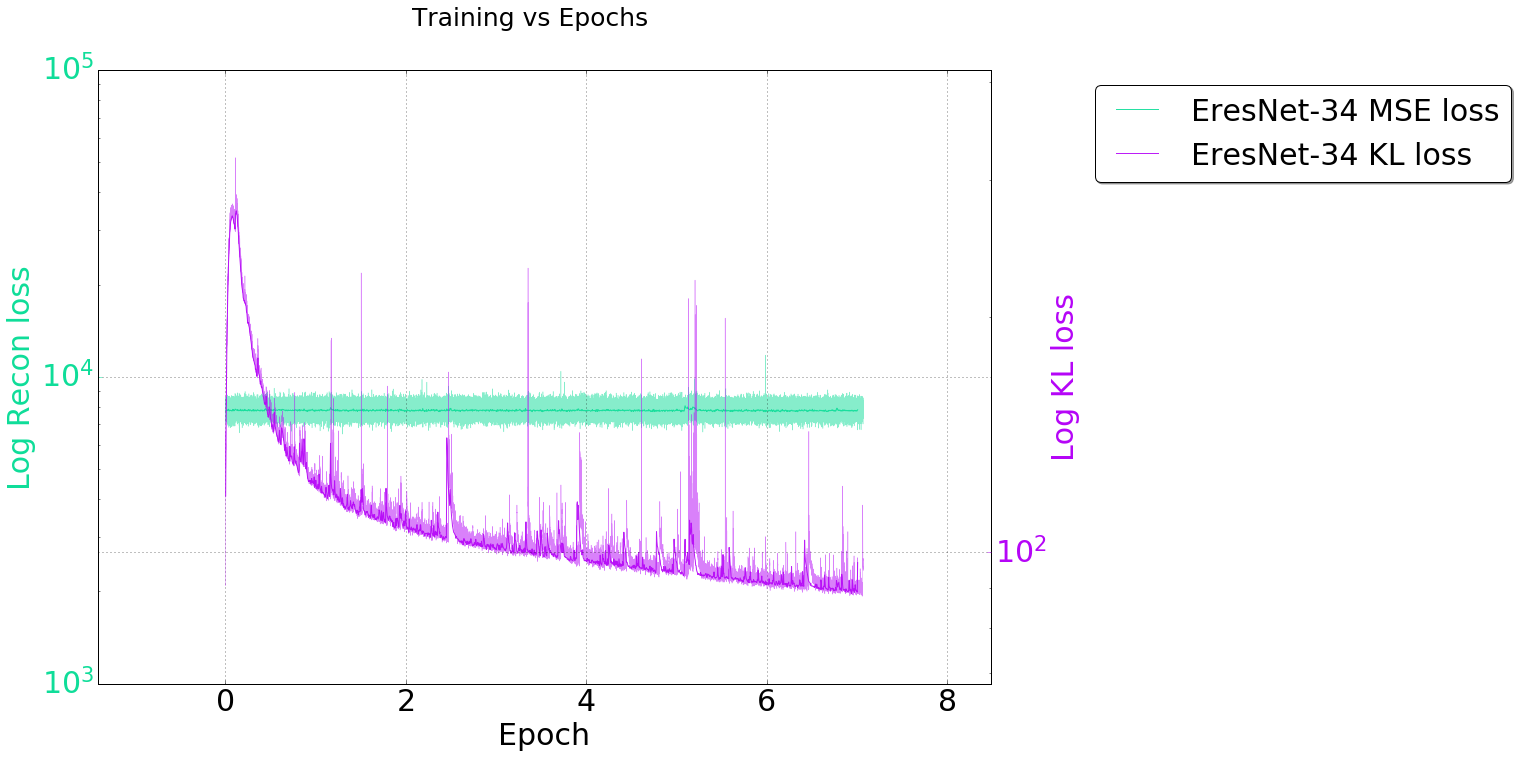

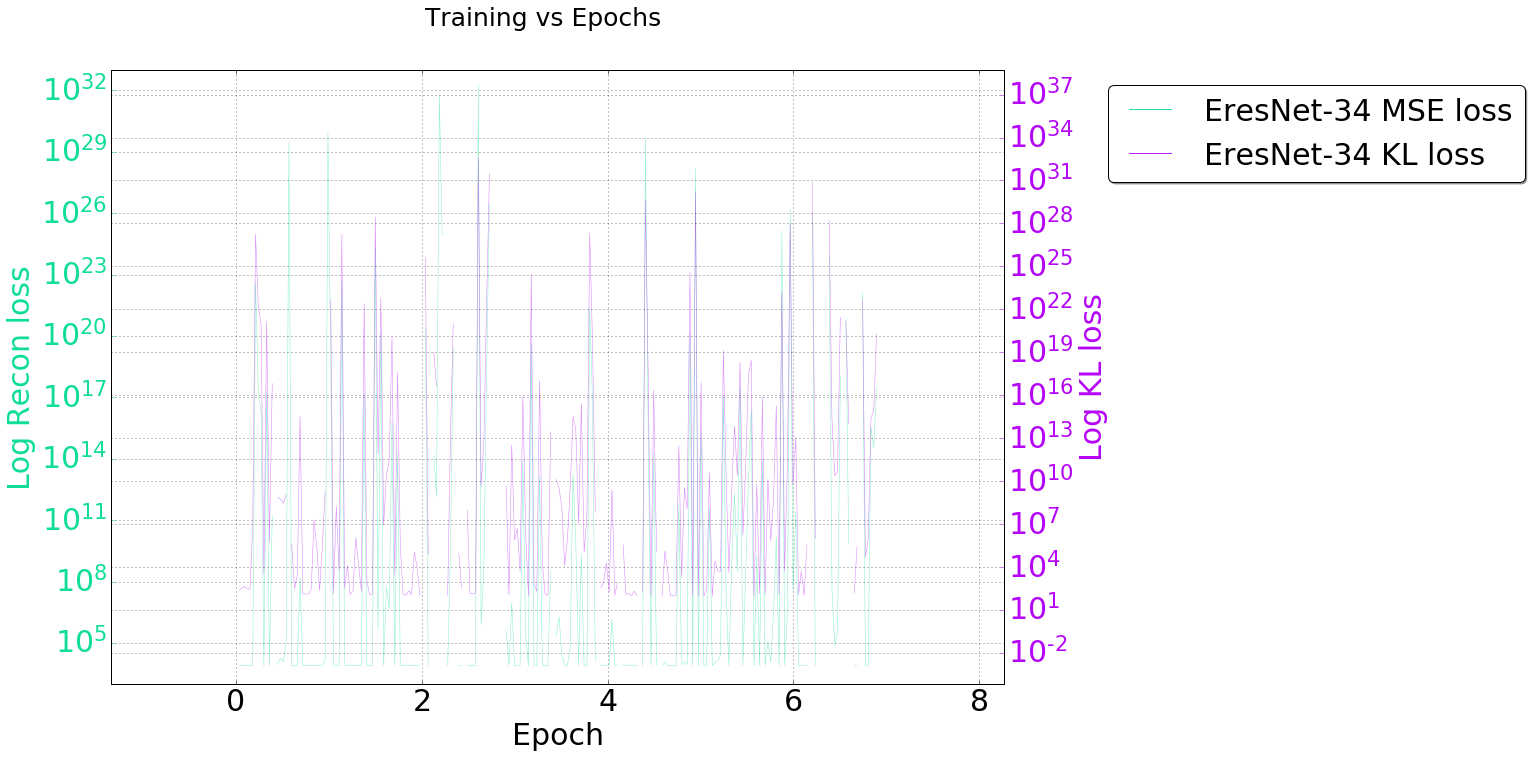

In [5]:
run_ids = ["20190929_184731"]
model_ids = ["EresNet-34"]

dump_dirs = ["/home/akajal/WatChMaL/VAE/dumps/" + run_id + "/" for run_id in run_ids]
training_logs = [dump_dir + "log_train.csv" for dump_dir in dump_dirs]
val_logs = [dump_dir + "log_val.csv" for dump_dir in dump_dirs]
    
local_color_dict = {key:[np.random.rand(3,),np.random.rand(3,)] for key in model_ids}

# Plot training log
plot_vae_training(training_logs, model_ids, 
                  local_color_dict,
                  downsample_interval=128,
                  legend_loc=(0.88,0.88),
                  show_plot=True)

# Plot validation log
plot_vae_training(val_logs, model_ids, 
                 local_color_dict,
                 downsample_interval=128,
                 legend_loc=(0.87,0.88),
                 show_plot=True)